Black Mamba venom model - Jeremy and Katie

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Model Idea Number 1

Question:

Explore how black mamba venom and antivenom interact with your body to determine the maximum amount of time between a bite and the administration of venom based on body weight. This is important to consider because it changes the lethal amount of venom that gets absorbed into the body.


Methods:

Black mamba venom contains dendrotoxins and a-neurotoxins. A-neurotoxins bind to neurotransmitter receptors, affectively blocking them from recieving any signals delivered by the neurotransmiter acetylcholine (ACh). This causes a build up of ACh as it is unable to bond to the blocked receptors. As the neurotransmitters become unable to recieve signals paralysis sets in. Dendrotoxins bind with and block the potassium channels of Kv1 cells which control the contraction of skeletal muscles. This causes overproduction of ACh as the body overcompensates for the unrecieved signals. The high ACh quantities fire muscles repeatedly causing spasms. In addition to these neurotoxins, black mamba venom also contains a high ACh content within it. The build up of ACh is ultimately what kills people through paralysis of the respiratory muscles, so that is what we will focus on. Too much ACh in the body causes muscle spasms, convulsions and eventually paralysis.


Antivenom is made by injecting large animals, usually horses, with small amounts of venom until their blood builds up enough antibodies to smother the venoms negative affects. The antibodies are then extracted and refined into antivenom. When the antivenom is injected into a bite victim the antibodies seek out and bind to the harmful molecules in the venom (in the black mamba these include the a-neurotoxins and dendrotoxins.) The toxins are then unable to bind with the body thus the antivenom doesn't repair the previous dammage, only prevents more.

We will find a rate for how fast the a-neurotoxins and dendrotoxins bind to both the receptors in the body and the proteins in the antivenom.

In [570]:
#defining stocks and flows

stocks = State(HAChR = 0, #healthy ACh receptors
              HKV1 = 0, #healthy Kv1
              BAChR = 0, #blocked ACh receptors
              BKV1 = 0, #blocked KV1
              atox = 0, #a toxin quantity
              dentox = 0, #dendrotoxin quantity
              AV = 0, #antivenom quantity
              AChV = 0, #ACh venom quantity
               ACh = 0) #ACh level total

flows = System(atox_blockage_rate = 0,
              dentox_blockage_rate  = 0,
              atox_antivenm_blockage_rate = 0,
              dentox_antivenom_blockage_rate = 0,
              ACh_build_up_rate = 0,
              ACh_overproduction_rate = 0)

,values
atox_blockage_rate,0
dentox_blockage_rate,0
atox_antivenm_blockage_rate,0
dentox_antivenom_blockage_rate,0
ACh_build_up_rate,0
ACh_overproduction_rate,0


For this model, we would have made two update functions, one that just modeled the venom travelling through the body and one that modeled both the venom and the antivenom, with a sweep through when the antivenom is first given, because the procedure for how to give antivenom is the same no matter when you start. We would sweep these results for a range of body weights. The results we would have expected from this would be graphs that show how long a person of a certain body weight would have before the antivenom must be administered in order to survive. Unfortunately, there was no data about how much of each of these proteins and receptors there are in the human body or venom so we were unable to make this model.

### Model Idea Number 2

Question:

How long can you wait to administer antivenom to a black mamba bite victim?

Methods:

In order to answer our question we used a well-documented case of a black mamba bite. From this we determined the rate of bonding between the venom and the person's body. Then we found the rate of bonding between the venom and the antivenom. Using this data we created a model that will tell you if you will survive depending on when the antivenom is administered. 

Mitzi Hazell is a 55 year old woman who survived a black mamba bite. Her story can be found here: https://www.enca.com/south-africa/black-mamba-bite-survivor-tells-her-tale  We had to make two assumptions about the situation in order to make the model work. Firstly, using average age-weight statistics we determined that she is 70kg. Secondly, we researched black mamba venom bite quantities and bassed on the size of the snake that bit her we determined she recieved a dose of 100mg of venom.

In [599]:
def make_system():

    init = State(FV = 100, AV = 50, BV = 0)     #FV is the unbonded venom left in the body. The avergae bite is 100mg of venom
                                                #AV is the amount of antivenom injected, in this case 50ml
                                                #BV is the amount of venom bonded to the body, it starts at zer
    AV_rate = -.005                             #AV_rate is the rate at which the antivenom bonds to the venom
    

    return System(init=init, AV_rate = AV_rate)

In [600]:
def update_func(state, t, system, Minutes_Until_AV):
    
    if (state.FV <= 0):              #if the venom is completly bonded the model ends
        print("Survived")
        return state, False
    
    if (state.BV >= 17.5):           #if the venom bonded to the body reaches 0.25mg of venom per kg of body mass the victim dies
        print("Painful death")
        return state, False
    
    
    fv = state.FV
    av = state.AV
    bv = state.BV
    
    

    #beta = .001068*state.FV
    receptorB = fv*math.log(.99882)*(.99882**t)     #Calculates the exponential rate at which the venom bonds the the body
    #fv = 400(1-.002234)**t
    antivenomB = av*system.AV_rate                  #The rate the antivenom bonds with the venom
    
    
    if t < Minutes_Until_AV:                        #simulates the body before the antivenom is injected
     
        fv += receptorB
        bv += abs(receptorB)
      
    
    else:                                          #simulates the injection of antivenom
    
        fv += receptorB + 2*antivenomB             #The antivenom bonds at a rate of 1ml antivenom: 2mg venom
        bv += abs(receptorB)
        av += antivenomB
    
    
    return State(FV = fv, AV = av, BV = bv), True

In [601]:
system = make_system()

,values
init,FV 100 AV 50 BV 0 dtype: int64
AV_rate,-0.005


In [602]:
def run_simulation(system, update_func, Minutes_Until_AV):     #time until antivenom injection is passed in and can be changed

    results = TimeFrame(columns=system.init.index)
    results.row[0] = system.init
    
    
    state = system.init
    
    t = 0
    while True: 
        
        results.row[t+1], flag = update_func(results.row[t], t, system, Minutes_Until_AV)
        
        
        if flag == False:
            return results
        
        t+=1
    

In [609]:
def plot_results(FV, AV, BV):
    plot(FV, '--', label='Unbonded Venom')
    plot(AV, '-', label='Unbonded Antivenom')
    plot(BV, ':', label='Venom bonded to body')
    decorate(xlabel='Time (minutes)',
             ylabel='Quantity')

Survived


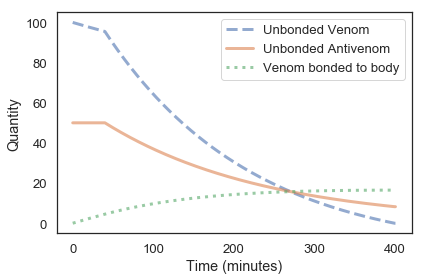

In [616]:
results = run_simulation(system, update_func, 40);
plot_results(results.FV, results.AV, results.BV)

For example, if the antivenom is administered after 40 minutes, then the victim survives because the ACh doesn't reach the lethal threshold of 17.5 mg of venom bonded. 

Painful death


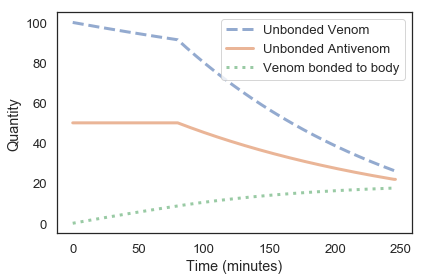

In [620]:
results = run_simulation(system, update_func, 80);
plot_results(results.FV, results.AV, results.BV)

However, if it's administered later, for example after 80 minutes, the victim dies. 

Interpretation:

Our model shows whether the victim of a black mamba bite will survive depending on when they recieve the antivenom. We found that 55 minutes is the critical threshold where any 50ml dose of antivenom administered after proves useless.This is only applicable to a situation similar to the one we researched because we were unable to find a wider set of data. Given more data we would be able to broaden this model to apply to anyone. 
    

Reflection:
    
We bit off more than we could chew on this project. Although we learned a lot about how black mamba venom works on different levels (micro and macro), we were unable to find the necessary data to make the model we had envisioned. Given more data, this model could be applied to any black mamba bite. Also, we could sweep most paramaters so that even without much more data this could be much more applicable. Next time we would give up sooner on our project when we realized the data simply didn't exist,  but we had already sunk so much time into understanding this model by the point that we decided to make it work somehow; it didn't.